In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

from catboost import CatBoostRegressor, Pool, metrics, cv

import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

In [2]:
def result_pred(pred, resY):
    print(f'mean_squared_error: {math.sqrt(mean_squared_error(resY, pred))}')
    print(f'mean_absolute_error: {mean_absolute_error(resY, pred)}')
    print(f'median_absolute_error: {median_absolute_error(resY, pred)}')
    print(f'r2_score: {r2_score(resY, pred)}')

In [3]:
def result_value(pred, resY):
    return [math.sqrt(mean_squared_error(resY, pred)),
            mean_absolute_error(resY, pred),
            median_absolute_error(resY, pred),
            r2_score(resY, pred)]

In [4]:
def result_table(args, resY, subcol=None, valueSubCol=None):
    if subcol and valueSubCol:
        dt = {subcol: valueSubCol,
            'mean_squared_error': [],
            'mean_absolute_error': [],
            'median_absolute_error': [],
            'r2_score': []}
    else:
        dt = {'mean_squared_error': [],
            'mean_absolute_error': [],
            'median_absolute_error': [],
            'r2_score': []}
    preds = args
    for pred in preds:
        tmp = result_value(pred, resY)
        dt['mean_squared_error'].append(tmp[0])
        dt['mean_absolute_error'].append(tmp[1])
        dt['median_absolute_error'].append(tmp[2])
        dt['r2_score'].append(tmp[3])
    return dt

# **Подгрузка данных и обработка**

In [5]:
data = pd.read_csv('cars_sampled.csv')

In [6]:
data

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
0,30/03/2016 13:51,Zu_verkaufen,private,offer,4450,test,limousine,2003,manual,150,3er,150000,3,diesel,bmw,NaN,30/03/2016 0:00,20257,7/4/2016 4:44
1,7/3/2016 9:54,Volvo_XC90_2.4D_Summum,private,offer,13299,control,suv,2005,manual,163,xc_reihe,150000,6,diesel,volvo,no,7/3/2016 0:00,88045,26/03/2016 13:17
2,1/4/2016 0:57,Volkswagen_Touran,private,offer,3200,test,bus,2003,manual,101,touran,150000,11,diesel,volkswagen,NaN,31/03/2016 0:00,27449,1/4/2016 8:40
3,19/03/2016 17:50,Seat_Ibiza_1.4_16V_Reference,private,offer,4500,control,small car,2006,manual,86,ibiza,60000,12,petrol,seat,no,19/03/2016 0:00,34537,7/4/2016 4:44
4,16/03/2016 14:51,Volvo_XC90_D5_Aut._RDesign_R_Design_AWD_GSHD_S...,private,offer,18750,test,suv,2008,automatic,185,xc_reihe,150000,11,diesel,volvo,no,16/03/2016 0:00,55270,1/4/2016 23:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,3/4/2016 15:48,Suche_VW_T5_Multivan,private,request,0,test,bus,2005,NaN,0,transporter,150000,0,NaN,volkswagen,NaN,3/4/2016 0:00,29690,5/4/2016 15:16
49997,27/03/2016 14:55,Suche_einen_originalen_VW_Golf_2_Fire_and_Ice_G60,private,request,19999,control,NaN,1990,NaN,0,golf,5000,0,NaN,volkswagen,NaN,27/03/2016 0:00,50181,7/4/2016 11:45
49998,14/03/2016 18:51,[SUCHE]_BMW_e46_Coupe_330ci_M_Paket_Facelift__...,private,request,0,test,coupe,2004,manual,0,3er,150000,1,petrol,bmw,no,14/03/2016 0:00,86956,25/03/2016 6:17
49999,15/03/2016 18:06,Verkaufe_mehrere_Fahrzeuge_zum_Verschrotten,commercial,offer,100,control,station wagon,2000,manual,0,megane,150000,8,petrol,renault,NaN,15/03/2016 0:00,65232,6/4/2016 17:15


## **Убираем не заполненые ценами данные**

In [7]:
data = data[(data.price > 0) & (data.powerPS > 0)]

In [8]:
data

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
0,30/03/2016 13:51,Zu_verkaufen,private,offer,4450,test,limousine,2003,manual,150,3er,150000,3,diesel,bmw,NaN,30/03/2016 0:00,20257,7/4/2016 4:44
1,7/3/2016 9:54,Volvo_XC90_2.4D_Summum,private,offer,13299,control,suv,2005,manual,163,xc_reihe,150000,6,diesel,volvo,no,7/3/2016 0:00,88045,26/03/2016 13:17
2,1/4/2016 0:57,Volkswagen_Touran,private,offer,3200,test,bus,2003,manual,101,touran,150000,11,diesel,volkswagen,NaN,31/03/2016 0:00,27449,1/4/2016 8:40
3,19/03/2016 17:50,Seat_Ibiza_1.4_16V_Reference,private,offer,4500,control,small car,2006,manual,86,ibiza,60000,12,petrol,seat,no,19/03/2016 0:00,34537,7/4/2016 4:44
4,16/03/2016 14:51,Volvo_XC90_D5_Aut._RDesign_R_Design_AWD_GSHD_S...,private,offer,18750,test,suv,2008,automatic,185,xc_reihe,150000,11,diesel,volvo,no,16/03/2016 0:00,55270,1/4/2016 23:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49992,14/03/2016 13:57,Opel_Astra_2.0_DI_Elegance,private,offer,790,test,limousine,1998,manual,82,astra,150000,9,diesel,opel,no,14/03/2016 0:00,99310,31/03/2016 0:45
49993,14/03/2016 11:37,Renault_Clio_mit_Servolenkung_und_neuem_TÜV!,private,offer,830,test,small car,1999,manual,60,clio,125000,8,petrol,renault,no,14/03/2016 0:00,33659,22/03/2016 4:47
49994,9/3/2016 1:36,Porsche_993,private,offer,175000,control,coupe,1998,manual,286,911,50000,2,petrol,porsche,no,9/3/2016 0:00,35418,14/03/2016 23:17
49995,23/03/2016 21:45,Opel_Astra_G_Caravan__Tuev_2/2018__Scheckheft_...,private,offer,2290,test,station wagon,2001,manual,101,astra,150000,3,petrol,opel,no,23/03/2016 0:00,27305,4/4/2016 1:47


## **Ищем пустые значения по другим колонкам**

In [9]:
data.isnull().sum()

dateCrawled               0
name                      0
seller                    0
offerType                 0
price                     0
abtest                    0
vehicleType            2942
yearOfRegistration        0
gearbox                 825
powerPS                   0
model                  1753
kilometer                 0
monthOfRegistration       0
fuelType               2662
brand                     0
notRepairedDamage      6406
dateCreated               0
postalCode                0
lastSeen                  0
dtype: int64

In [10]:
data['vehicleType'].value_counts()

vehicleType
limousine        11929
small car         9440
station wagon     8200
bus               3637
cabrio            2828
coupe             2328
suv               1856
others             342
Name: count, dtype: int64

In [11]:
data['gearbox'].value_counts()

gearbox
manual       33056
automatic     9621
Name: count, dtype: int64

In [12]:
data['fuelType'].value_counts()

fuelType
petrol     26931
diesel     13084
lpg          699
cng           71
hybrid        36
electro       12
other          7
Name: count, dtype: int64

In [13]:
data['notRepairedDamage'].value_counts()

notRepairedDamage
no     33017
yes     4079
Name: count, dtype: int64

In [14]:
data['model'].value_counts()

model
golf          3530
others        2959
3er           2523
polo          1522
corsa         1418
              ... 
b_max            1
serie_3          1
elefantino       1
charade          1
rangerover       1
Name: count, Length: 247, dtype: int64

In [15]:
data['vehicleType'] = data['vehicleType'].fillna('coupe')
data['gearbox'] = data['gearbox'].fillna('manual')
data['fuelType'] = data['fuelType'].fillna('petrol')
data['notRepairedDamage'] = data['notRepairedDamage'].fillna('no')
data['model'] = data['model'].fillna('golf')

C:\Users\Egor\AppData\Local\Temp\ipykernel_24476\431619664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['vehicleType'] = data['vehicleType'].fillna('coupe')
C:\Users\Egor\AppData\Local\Temp\ipykernel_24476\431619664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gearbox'] = data['gearbox'].fillna('manual')
C:\Users\Egor\AppData\Local\Temp\ipykernel_24476\431619664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

## **Убираем не нужные колонки**

In [16]:
data[data.offerType != 'offer']

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen


In [17]:
data = data.drop(columns=['name', 'seller', 'dateCrawled', 'lastSeen', 'dateCreated', 'postalCode', 'offerType', 'monthOfRegistration', 'abtest'])

In [18]:
data['fuelType'] = data['fuelType'].replace('other', 'petrol')

In [19]:
data

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
0,4450,limousine,2003,manual,150,3er,150000,diesel,bmw,no
1,13299,suv,2005,manual,163,xc_reihe,150000,diesel,volvo,no
2,3200,bus,2003,manual,101,touran,150000,diesel,volkswagen,no
3,4500,small car,2006,manual,86,ibiza,60000,petrol,seat,no
4,18750,suv,2008,automatic,185,xc_reihe,150000,diesel,volvo,no
...,...,...,...,...,...,...,...,...,...,...
49992,790,limousine,1998,manual,82,astra,150000,diesel,opel,no
49993,830,small car,1999,manual,60,clio,125000,petrol,renault,no
49994,175000,coupe,1998,manual,286,911,50000,petrol,porsche,no
49995,2290,station wagon,2001,manual,101,astra,150000,petrol,opel,no


## **Проверка на выбросы**

**Анамальными могут оказаться колонки: price, yearOfRegistration, powerPS, kilometer их мы и будем проверять**

<Axes: xlabel='kilometer'>

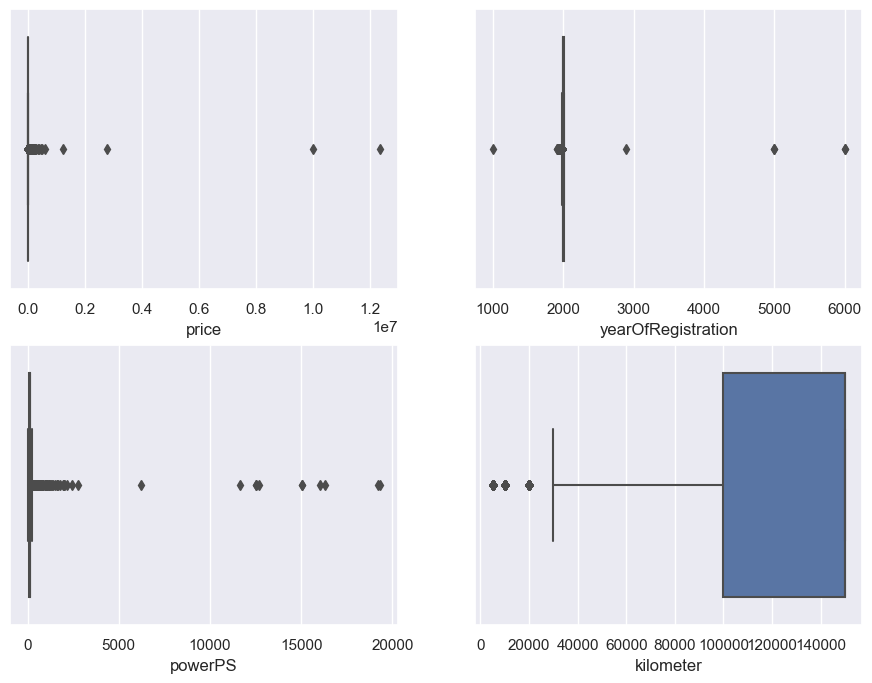

In [20]:
sns.set(rc={'figure.figsize': (11, 8)})

fig, axes = plt.subplots(2, 2)

sns.boxplot(x=data.price, ax=axes[0, 0])
sns.boxplot(x=data.yearOfRegistration, ax=axes[0, 1])
sns.boxplot(x=data.powerPS, ax=axes[1, 0])
sns.boxplot(x=data.kilometer, ax=axes[1, 1])

In [21]:
data = data[(data['yearOfRegistration'] >= 1960) & (data['yearOfRegistration'] <= 2023) &
      (data['powerPS'] <= 2200) & (data.price <= 300000) & (data['kilometer'] > 21000)]

In [22]:
data

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
0,4450,limousine,2003,manual,150,3er,150000,diesel,bmw,no
1,13299,suv,2005,manual,163,xc_reihe,150000,diesel,volvo,no
2,3200,bus,2003,manual,101,touran,150000,diesel,volkswagen,no
3,4500,small car,2006,manual,86,ibiza,60000,petrol,seat,no
4,18750,suv,2008,automatic,185,xc_reihe,150000,diesel,volvo,no
...,...,...,...,...,...,...,...,...,...,...
49992,790,limousine,1998,manual,82,astra,150000,diesel,opel,no
49993,830,small car,1999,manual,60,clio,125000,petrol,renault,no
49994,175000,coupe,1998,manual,286,911,50000,petrol,porsche,no
49995,2290,station wagon,2001,manual,101,astra,150000,petrol,opel,no


## **А так же надо убрать не понятные марки автомобилей**

In [23]:
data['brand'].unique()

array(['bmw', 'volvo', 'volkswagen', 'seat', 'mercedes_benz', 'opel',
       'skoda', 'toyota', 'nissan', 'sonstige_autos', 'mazda',
       'mitsubishi', 'audi', 'fiat', 'alfa_romeo', 'saab', 'peugeot',
       'land_rover', 'subaru', 'mini', 'citroen', 'jeep', 'chrysler',
       'ford', 'renault', 'dacia', 'chevrolet', 'smart', 'trabant',
       'suzuki', 'hyundai', 'honda', 'jaguar', 'daihatsu', 'porsche',
       'kia', 'rover', 'lancia', 'daewoo', 'lada'], dtype=object)

In [24]:
data = data[data['brand'] != 'sonstige_autos']

## **Сохраним итоговую таблицу на всякий случай**

In [25]:
data.to_csv('TrainTestDATA.csv')

## **Работа с категориальными признаками**

In [26]:
le = LabelEncoder()
label = le.fit_transform(data['model'])
data.drop('model', axis=1, inplace=True)
data['model'] = label

data = pd.get_dummies(data, columns=['vehicleType'])
data = pd.get_dummies(data, columns=['gearbox'])
data = pd.get_dummies(data, columns=['fuelType'])

data['brand'] = data['brand'].astype('category')
data['brand'] = data['brand'].cat.codes

data['notRepairedDamage'] = data['notRepairedDamage'].astype('category')
data['notRepairedDamage'] = data['notRepairedDamage'].cat.codes

for elem in data.iloc[:, :]:
    data[elem] = data[elem].map(int)

C:\Users\Egor\AppData\Local\Temp\ipykernel_24476\27284621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('model', axis=1, inplace=True)
C:\Users\Egor\AppData\Local\Temp\ipykernel_24476\27284621.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['model'] = label


## **Посмотрим на получившиеся данные и построим матрицу корреляции**

In [27]:
data

,price,yearOfRegistration,powerPS,kilometer,brand,notRepairedDamage,model,vehicleType_bus,vehicleType_cabrio,vehicleType_coupe,...,vehicleType_station wagon,vehicleType_suv,gearbox_automatic,gearbox_manual,fuelType_cng,fuelType_diesel,fuelType_electro,fuelType_hybrid,fuelType_lpg,fuelType_petrol
0,4450,2003,150,150000,2,0,11,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,13299,2005,163,150000,38,0,241,0,0,0,...,0,1,0,1,0,1,0,0,0,0
2,3200,2003,101,150000,37,0,219,1,0,0,...,0,0,0,1,0,1,0,0,0,0
3,4500,2006,86,60000,30,0,120,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,18750,2008,185,150000,38,0,241,0,0,0,...,0,1,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49992,790,1998,82,150000,24,0,42,0,0,0,...,0,0,0,1,0,1,0,0,0,0
49993,830,1999,60,125000,27,0,75,0,0,0,...,0,0,0,1,0,0,0,0,0,1
49994,175000,1998,286,50000,26,0,25,0,0,1,...,0,0,0,1,0,0,0,0,0,1
49995,2290,2001,101,150000,24,0,42,0,0,0,...,1,0,0,1,0,0,0,0,0,1


<Axes: >

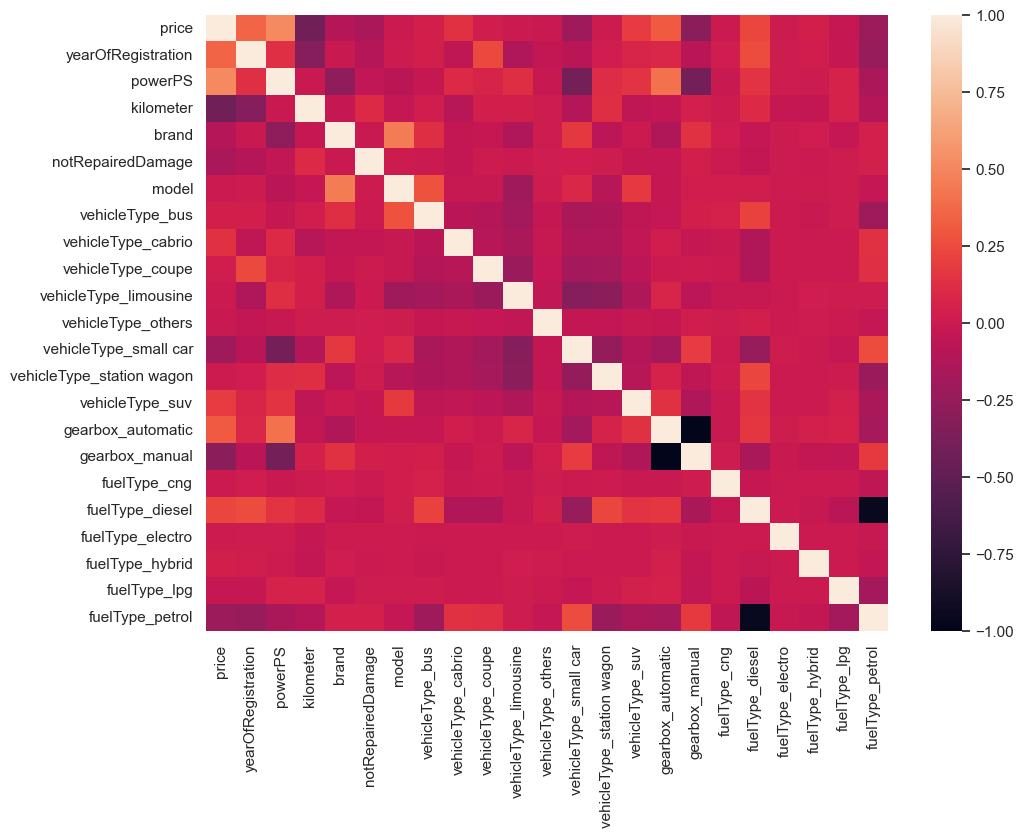

In [28]:
corr_matrix = data.corr()

sns.set(rc={'figure.figsize': (11, 8)})

sns.heatmap(corr_matrix, annot=False)

## **Делим данные**

In [30]:
X = data.drop(columns=['price'])
Y = data['price']

# **Разделение на тренеровочную и тестовую выборку**

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# **Выбор модели**

## **LinearRegression**

In [32]:
model_LR = LinearRegression()

model_LR.fit(X_train, Y_train)

pred_model_LR = model_LR.predict(X_test)

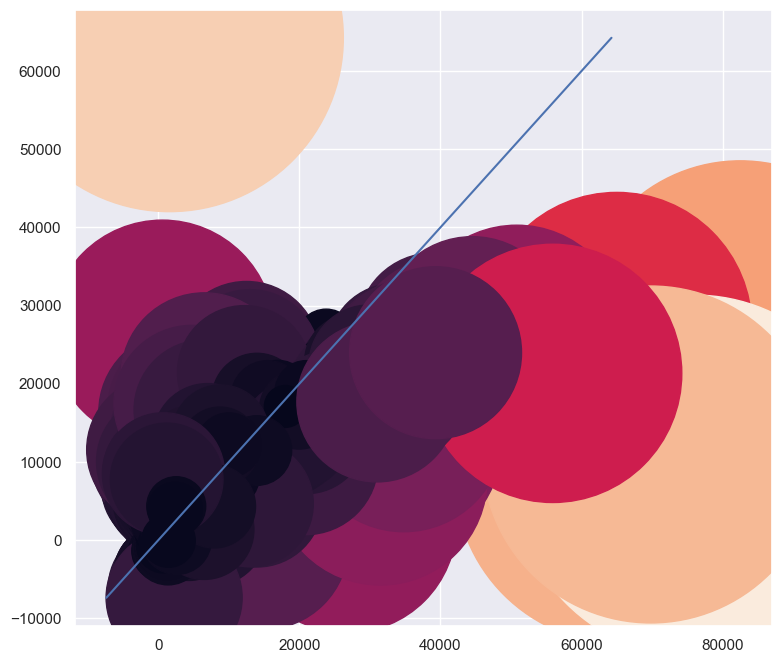

In [35]:
test_predictions = np.array(pred_model_LR)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(9, 8))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [36]:
result_pred(pred_model_LR, Y_test)

mean_squared_error: 4323.025421525386
mean_absolute_error: 2657.454703836101
median_absolute_error: 1873.277777684314
r2_score: 0.5822167038724017


In [37]:
model_LR_pereb = LinearRegression()

params = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1],
    'positive': [True, False]
}

search_model_LR = GridSearchCV(model_LR_pereb, params, n_jobs=-1, cv=5, refit=True, scoring='neg_mean_absolute_error')

search_model_LR.fit(X_train, Y_train)

print(search_model_LR.best_params_)

search_model_LR = search_model_LR.best_estimator_

prediction_search_model_LR = search_model_LR.predict(X_test)

{'copy_X': True, 'fit_intercept': False, 'n_jobs': -1, 'positive': False}


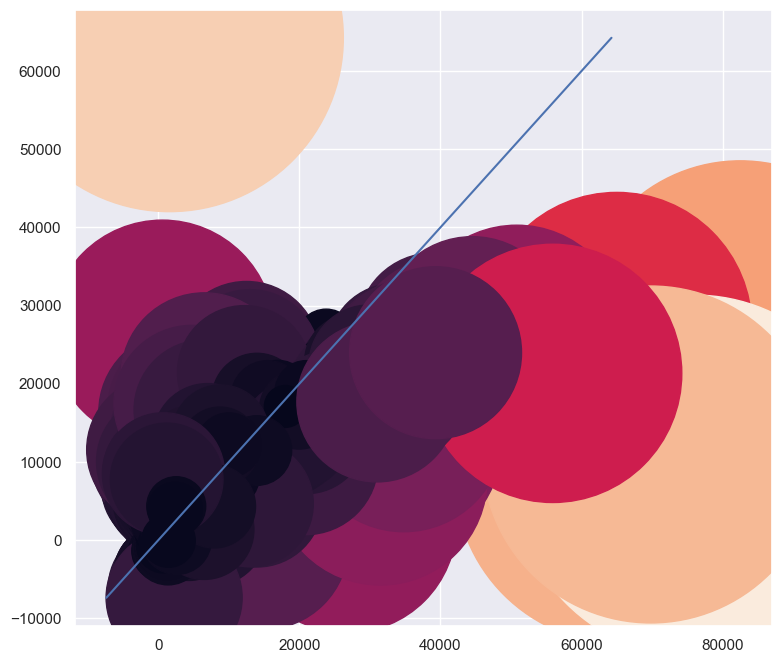

In [38]:
test_predictions = np.array(prediction_search_model_LR)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(9, 8))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [39]:
result_pred(prediction_search_model_LR, Y_test)

mean_squared_error: 4323.025421525392
mean_absolute_error: 2657.4547038361848
median_absolute_error: 1873.2777776846197
r2_score: 0.5822167038724007


## **CatBoostRegressor**

In [40]:
model_CBR = CatBoostRegressor(task_type='GPU')

model_CBR.fit(X_train, Y_train, verbose=500)

predcit_model_CBR = model_CBR.predict(X_test)

Learning rate set to 0.064962
0:	learn: 7412.6680122	total: 26.7ms	remaining: 26.7s
500:	learn: 2845.1235344	total: 9.04s	remaining: 9s
999:	learn: 2769.1947840	total: 17.2s	remaining: 0us


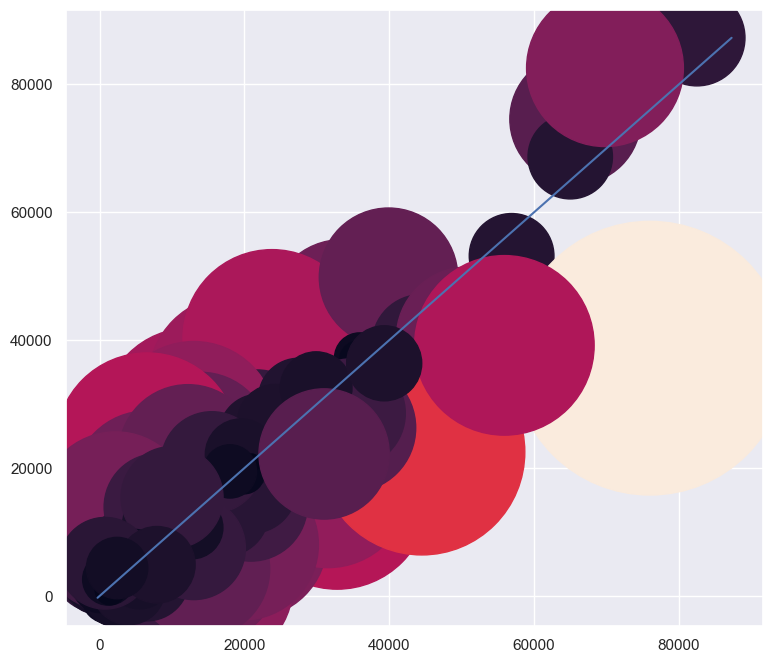

In [41]:
test_predictions = np.array(predcit_model_CBR)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(9, 8))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [42]:
result_pred(predcit_model_CBR, Y_test)

mean_squared_error: 2264.8240645153505
mean_absolute_error: 1297.8842061565945
median_absolute_error: 746.6535047171637
r2_score: 0.8853314198641093


In [43]:
model_search_CBR = CatBoostRegressor(iterations=7001,
                                     rsm=1,
                                     early_stopping_rounds=100,
                                     grow_policy='Depthwise',
                                     depth=6,
                                     loss_function='RMSE',
                                     eval_metric='RMSE',
                                     l2_leaf_reg=15,
                                     learning_rate=0.05,
                                     border_count=300,
                                     verbose=1000,
                                     task_type='GPU'
                                     )

model_search_CBR.fit(X_train, Y_train)

0:	learn: 7469.0693282	total: 11.7ms	remaining: 1m 21s
1000:	learn: 2100.9580839	total: 6.75s	remaining: 40.5s
2000:	learn: 1753.3828635	total: 13.8s	remaining: 34.4s
3000:	learn: 1590.7806370	total: 22.5s	remaining: 30s
4000:	learn: 1486.7308400	total: 29.8s	remaining: 22.3s
5000:	learn: 1415.0143463	total: 35.7s	remaining: 14.3s
6000:	learn: 1360.8829153	total: 41.6s	remaining: 6.93s
7000:	learn: 1319.2678720	total: 48.6s	remaining: 0us


In [44]:
pred_model_search_CBR = model_search_CBR.predict(X_test)

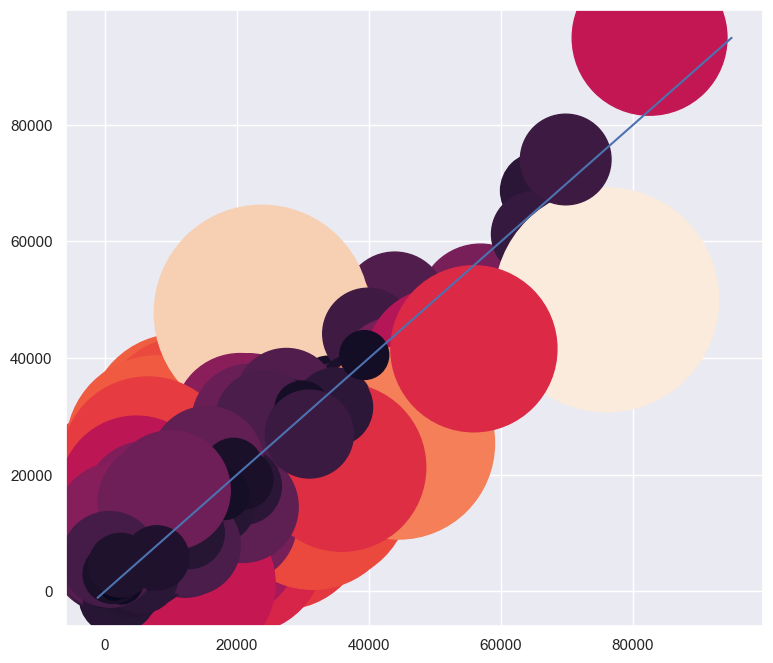

In [45]:
test_predictions = np.array(pred_model_search_CBR)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(9, 8))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [46]:
result_pred(pred_model_search_CBR, Y_test)

mean_squared_error: 2110.721755026783
mean_absolute_error: 1178.205291042121
median_absolute_error: 637.2041493672314
r2_score: 0.9004050160509375


## **LassoCV**

In [47]:
LCV = LassoCV()

LCV.fit(X_train, Y_train)

prediction_LCV = LCV.predict(X_test)

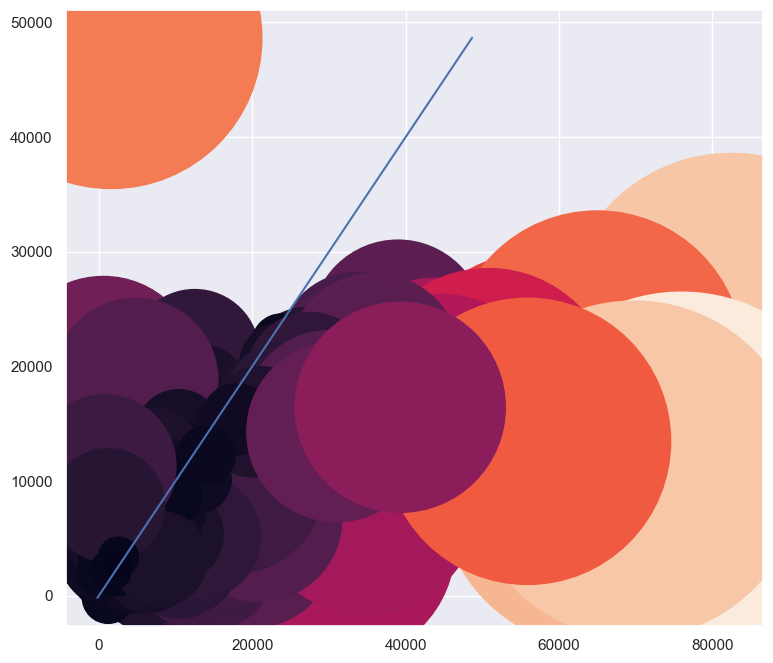

In [48]:
test_predictions = np.array(prediction_LCV)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(9, 8))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [49]:
result_pred(prediction_LCV, Y_test)

mean_squared_error: 5041.575559748093
mean_absolute_error: 3172.819341520745
median_absolute_error: 2117.882505010073
r2_score: 0.43179107092467217


## **RidgeCV**

In [50]:
RCV = RidgeCV()

RCV.fit(X_train, Y_train)

prediction_RCV = RCV.predict(X_test)

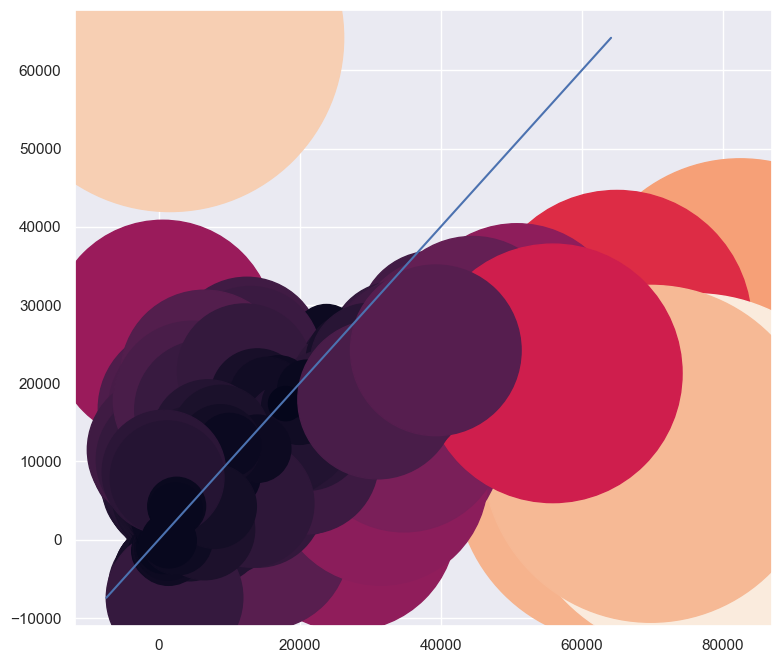

In [51]:
test_predictions = np.array(prediction_RCV)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(9, 8))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [52]:
result_pred(prediction_RCV, Y_test)

mean_squared_error: 4331.988274482111
mean_absolute_error: 2675.542787002471
median_absolute_error: 1878.191131121741
r2_score: 0.5804825424368365


In [53]:
search_RCV = RidgeCV(cv=50)

search_RCV.fit(X_train, Y_train)

prediction_search_RCV = search_RCV.predict(X_test)

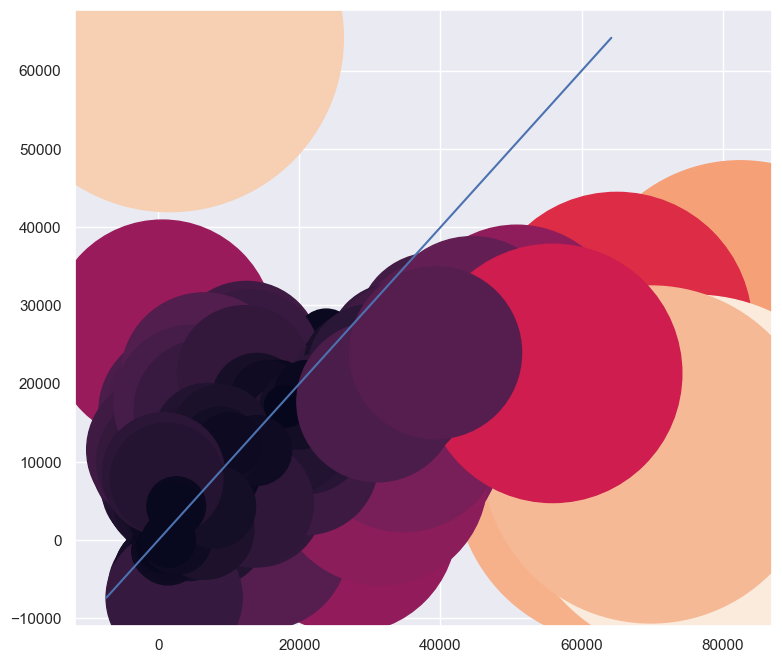

In [54]:
test_predictions = np.array(prediction_search_RCV)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(9, 8))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [55]:
result_pred(prediction_RCV, Y_test)

mean_squared_error: 4331.988274482111
mean_absolute_error: 2675.542787002471
median_absolute_error: 1878.191131121741
r2_score: 0.5804825424368365


## **ElasticNetCV**

In [56]:
ENCV = ElasticNetCV()

ENCV.fit(X_train, Y_train)

prediction_ENCV = ENCV.predict(X_test)

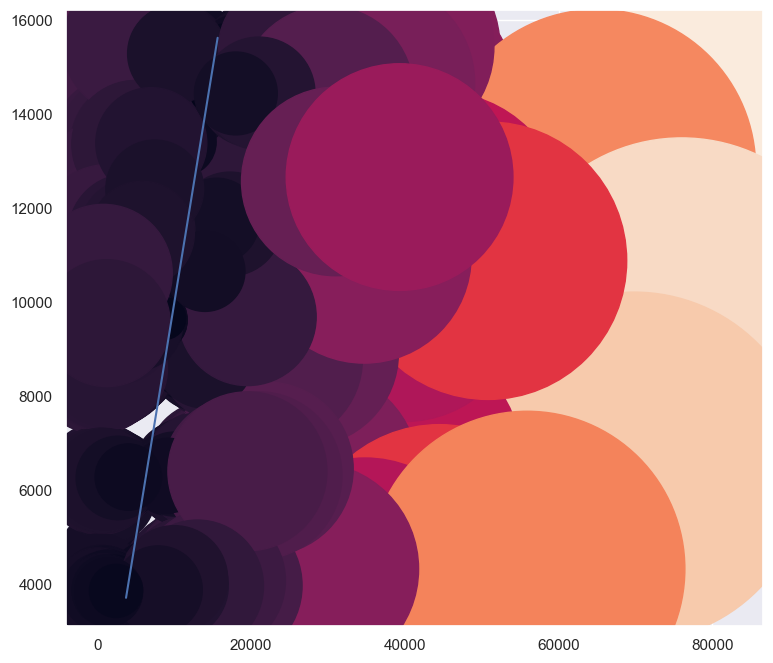

In [57]:
test_predictions = np.array(prediction_ENCV)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(9, 8))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [58]:
result_pred(prediction_ENCV, Y_test)

mean_squared_error: 6051.3328709432535
mean_absolute_error: 4043.4879209455103
median_absolute_error: 2925.640006721349
r2_score: 0.18138899354234383


In [59]:
search_ENCV = ElasticNetCV(eps=1e-8,
                           l1_ratio=0.8,
                           max_iter=50,
                           n_alphas=50,
                           random_state=25,
                           selection='random',
                           tol=1e-5)

search_ENCV.fit(X_train, Y_train)

prediction_search_ENCV = search_ENCV.predict(X_test)

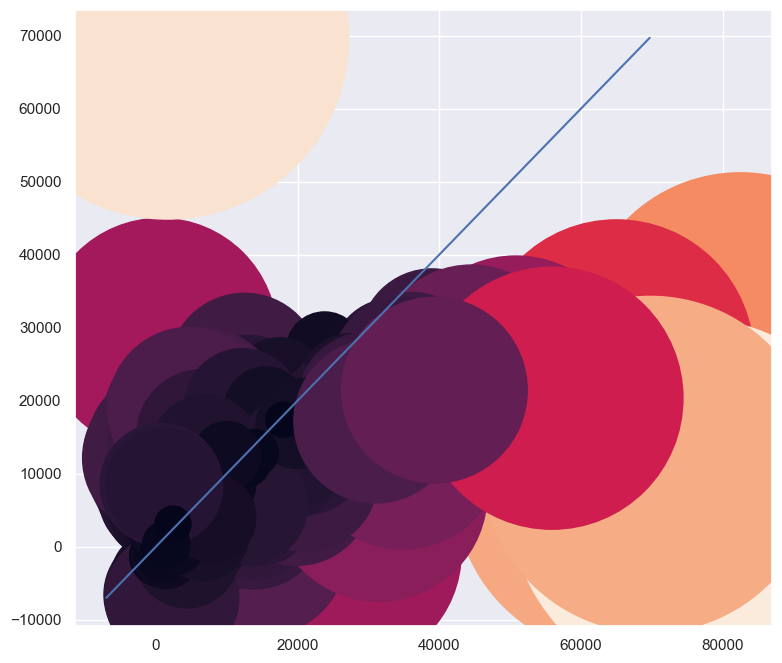

In [60]:
test_predictions = np.array(prediction_search_ENCV)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(9, 8))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [61]:
result_pred(prediction_search_ENCV, Y_test)

mean_squared_error: 4396.321804404749
mean_absolute_error: 2632.3133447302916
median_absolute_error: 1759.5575121779693
r2_score: 0.5679296721538395


In [83]:
GRB = GradientBoostingRegressor()

GRB.fit(X_train, Y_train)

prediction_GRB = GRB.predict(X_test)

In [84]:
result_pred(prediction_GRB, Y_test)

mean_squared_error: 2685.9050985287877
mean_absolute_error: 1516.6153642173804
median_absolute_error: 885.6381243681285
r2_score: 0.8387287989286244


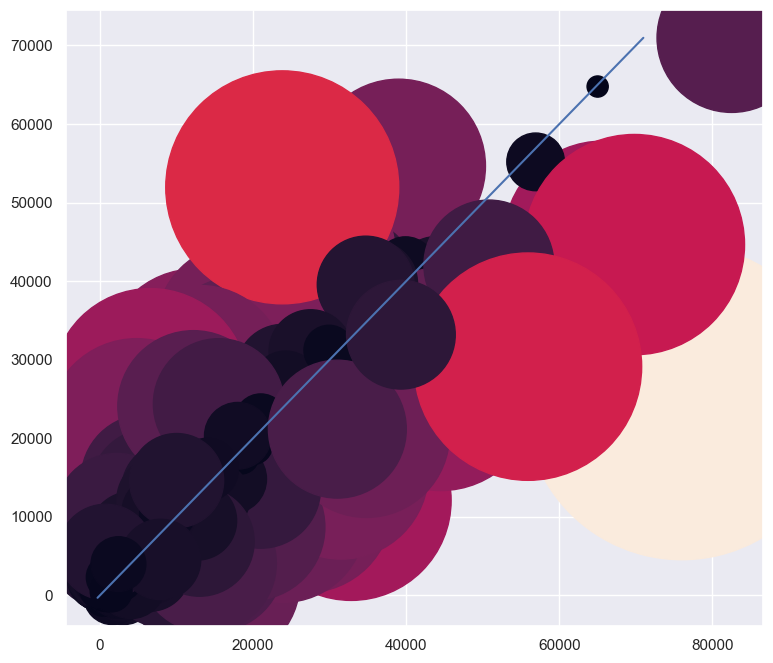

In [85]:
test_predictions = np.array(prediction_GRB)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(9, 8))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [86]:
search_GRB = GradientBoostingRegressor(loss='absolute_error',
                                       learning_rate=0.5,
                                       n_estimators=500,
                                       max_depth=6,
                                       min_samples_split=150,
                                       min_samples_leaf=175,
                                       min_weight_fraction_leaf=0.0000001)

search_GRB.fit(X_train, Y_train)

prediction_search_GRB = search_GRB.predict(X_test)

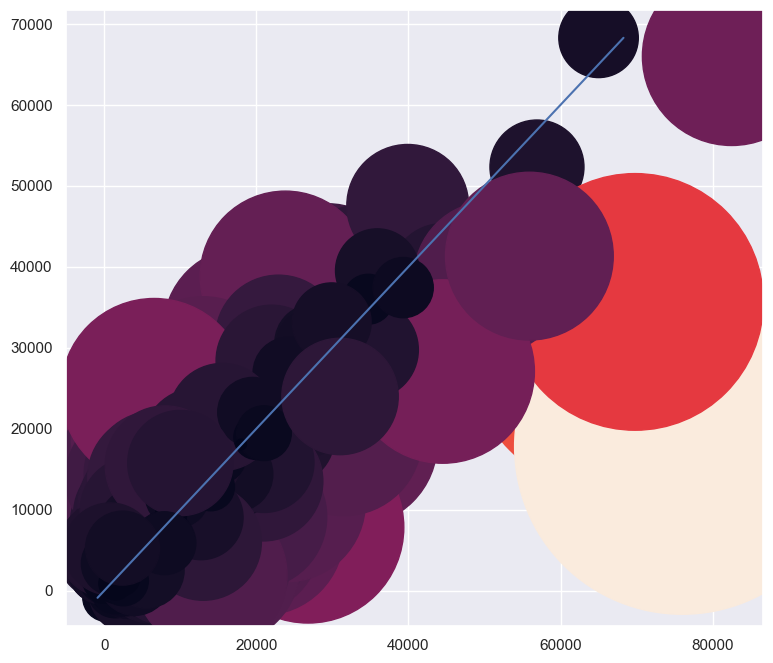

In [87]:
test_predictions = np.array(prediction_search_GRB)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(9, 8))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [88]:
result_pred(prediction_search_GRB, Y_test)

mean_squared_error: 2405.086517885387
mean_absolute_error: 1223.4330177295865
median_absolute_error: 637.2476850913483
r2_score: 0.8706885740594961


## **Сравнимаем результаты**

In [89]:
comparison_table = pd.DataFrame(result_table([pred_model_LR,
                                              prediction_search_model_LR,
                                              predcit_model_CBR,
                                              pred_model_search_CBR,
                                              prediction_LCV,
                                              prediction_RCV,
                                              prediction_search_RCV,
                                              prediction_ENCV,
                                              prediction_search_ENCV,
                                              prediction_GRB,
                                              prediction_search_GRB],
                                              Y_test,
                                              subcol='models',
                                              valueSubCol=['LinearRegression', 'search_LinearRegression',
                                                            'CatBoostRegressor', 'search_CatBoostRegressor',
                                                              'LassoCV', 'RidgeCV', 'search_RidgeCV',
                                                                'ElasticNetCV', 'search_ElasticNetCV',
                                                                'GradientBoostingRegressor', 'search_GradientBoostingRegressor']))

In [90]:
comparison_table

,models,mean_squared_error,mean_absolute_error,median_absolute_error,r2_score
0,LinearRegression,4323.025422,2657.454704,1873.277778,0.582217
1,search_LinearRegression,4323.025422,2657.454704,1873.277778,0.582217
2,CatBoostRegressor,2264.824065,1297.884206,746.653505,0.885331
3,search_CatBoostRegressor,2110.721755,1178.205291,637.204149,0.900405
4,LassoCV,5041.575560,3172.819342,2117.882505,0.431791
5,RidgeCV,4331.988274,2675.542787,1878.191131,0.580483
6,search_RidgeCV,4322.983537,2656.951141,1874.853342,0.582225
7,ElasticNetCV,6051.332871,4043.487921,2925.640007,0.181389
8,search_ElasticNetCV,4396.321804,2632.313345,1759.557512,0.567930
9,GradientBoostingRegressor,2685.905099,1516.615364,885.638124,0.838729


### **Из всех моделей хорошо себя показали model_search_CBR и model_CBR**

## **Обучим на всех данных и затестим**

In [64]:
model_CBR.fit(X, Y, verbose=500)

Learning rate set to 0.065865
0:	learn: 7317.6042027	total: 18.3ms	remaining: 18.2s
500:	learn: 2761.9306608	total: 8.6s	remaining: 8.56s
999:	learn: 2643.6169177	total: 16.1s	remaining: 0us


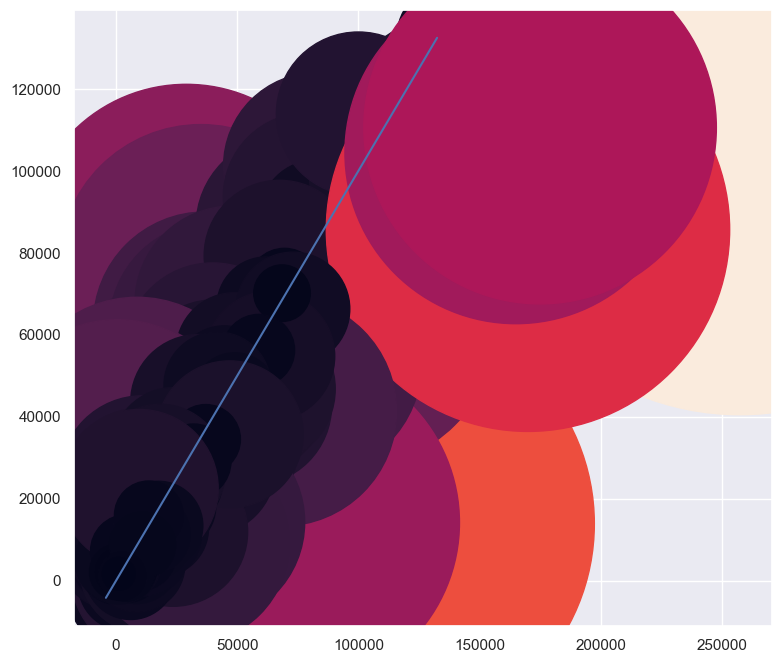

In [65]:
test_predictions = np.array(model_CBR.predict(X))
area = abs(Y - test_predictions)
plt.figure(figsize=(9, 8))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y, test_predictions, marker='o', s=area, c=area)

In [66]:
model_search_CBR.fit(X, Y)

0:	learn: 7370.8323726	total: 17.1ms	remaining: 1m 59s
1000:	learn: 2078.7590321	total: 8.81s	remaining: 52.8s
2000:	learn: 1752.2532371	total: 16.3s	remaining: 40.8s
3000:	learn: 1594.2994137	total: 24.7s	remaining: 33s
4000:	learn: 1492.5923756	total: 32s	remaining: 24s
5000:	learn: 1421.8171504	total: 39.1s	remaining: 15.6s
6000:	learn: 1368.3221386	total: 45.6s	remaining: 7.6s
7000:	learn: 1325.8528339	total: 52.2s	remaining: 0us


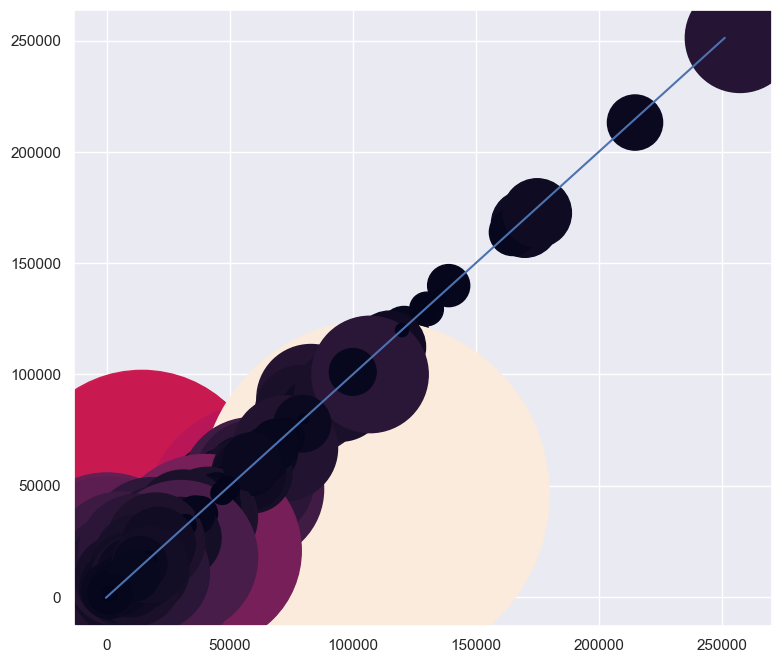

In [67]:
test_predictions = np.array(model_search_CBR.predict(X))
area = abs(Y - test_predictions)
plt.figure(figsize=(9, 8))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y, test_predictions, marker='o', s=area, c=area)

In [73]:
comparison_table = pd.DataFrame(result_table([model_CBR.predict(X),
                                              model_search_CBR.predict(X)],
                                              Y,
                                              subcol='models',
                                              valueSubCol=['model_CBR', 'model_search_CBR']))

In [75]:
comparison_table.iloc[1:, 1:]

,mean_squared_error,mean_absolute_error,median_absolute_error,r2_score
1,1325.852697,822.504833,531.359561,0.969627


In [69]:
comparison_table

,models,mean_squared_error,mean_absolute_error,median_absolute_error,r2_score
0,model_CBR,2643.616871,1327.341073,746.093603,0.879246
1,model_search_CBR,1325.852697,822.504833,531.359561,0.969627


## **Сохраним лучшую модель**

In [70]:
with open('bestModelThree.bf', '+wb') as bestModel:
    pickle.dump(model_search_CBR, bestModel)